In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Ordinal Regression/Output')
cur_date = "061724"

library(readxl)
library(openxlsx)
library(tidyverse)
library(gtsummary)
library(ordinalNet)
library(reshape2)
library(rstatix)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpubr)

# reading in file
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_061424.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,E
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,N
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score
,<chr>,<chr>,<dbl>
1,Cortisol,CS_M_18_B_1,0.4683470
2,Cortisol,CS_F_20_W_2,0.8342112
3,Cortisol,CS_F_20_W_3,0.1603803
4,Cortisol,CS_F_21_W_4,0.4583014
5,Cortisol,CS_M_21_W_5,0.3867217
6,Cortisol,CS_F_22_W_6,0.1712352


Calculating allostatic load (AL) scores for each subject, which serves as a measure for stress.

1. **Acute AL**

    In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 4 acute stress biomarkers (Noradrenaline, epinephrine, cortisol, and fibrinogen). Might run models with and without fibrinogen, since it could be considered a chronic biomarker.
    

3. **Chronic (secondary/tertiary) AL**
   
    No deriving of ordinal weights in this analysis, since we don't have an outcome that we measured associated with chronic stress. We'll include 3 chronic stress biomarkers (CRP, Hba1c, and HDL). 
    

5. **Overall AL**
   
    Summing the acute and chronic AL scores.

# Acute AL
Starting by combining the dataframes.

In [3]:
# creating a vector for variables that increase acute stress
acute_biomarkers = c('Cortisol','Noradrenaline','Epinephrine')#,'Fibrinogen')

ordinal_regression = function(dataset){
    # add words!!!!!
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining acute biomarkers only
        filter(Variable %in% acute_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:10,2)]#[,c(1,8:11,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(mediator_scores_df)

head(reg_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.3867217,0.9216080,0.02133767,N
CS_M_24_W_8,0.4378417,0.5058597,0.02155180,N
CS_M_25_W_10,0.2932014,0.8479016,0.18657420,E
CS_M_28_W_16,0.2416750,0.5058597,0.48633181,N
CS_M_29_W_17,0.5472276,0.3352036,0.35658497,N
CS_F_31_B_21,0.3620846,0.2770528,0.16448963,N


## Assessing Distributions

Looking at the distributions of blood pressure classifications and the mediator scores for each variable.

In [4]:
table(reg_df$BP_Classification)


 1  2  E  N 
 6  1  9 18 

The stage 1 and stage 2 classes are on the smaller side with 6 and 1 subject, respectively. There weren't enough observation of the stage 2 class to perform SMOTE; therefore, the blood pressure classes will be condensed in two different ways:

+ **3 classes**: Normal subjects, at risk (elevated) subjects, and hypertensive subjects (formerly stage 1 and stage 2 subjects)
+ **2 classes**: Normal subjects and hypertensive subjects (formerly elevated, stage 1, and stage 2 subjects)

In [5]:
three_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2"), "H", BP_Classification))

two_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2", "E"), "H", BP_Classification))

# turning BP into a factor
three_reg_df$BP_Classification = factor(three_reg_df$BP_Classification, levels = c("N", "E", "H"))
two_reg_df$BP_Classification = factor(two_reg_df$BP_Classification, levels = c("N", "H"))

In [6]:
table(two_reg_df$BP_Classification)
table(three_reg_df$BP_Classification)


 N  H 
18 16 


 N  E  H 
18  9  7 

Now assessing normality of the biomarkers using a shapiro wilk test.

In [7]:
# using a shapiro wilk test to assess normality
do.call(rbind.data.frame, apply(reg_df[,2:4], 2, shapiro.test))[,1:3] %>%
    # adding a column that clarifies whether or not a variable is normally distributed or not
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.7429965,2.411103e-06,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9351777,4.436357e-02,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9389878,5.752138e-02,Shapiro-Wilk normality test,Normal


Only 1 variable was normally distributed; therefore, we'll perform a data transformation (pseudo log 2) to see if that helps.

In [8]:
pslog2_df = reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(pslog2_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,E
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,N
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


In [9]:
do.call(rbind.data.frame, apply(pslog2_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.8080826,3.687146e-05,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9528941,1.498883e-01,Shapiro-Wilk normality test,Normal
Epinephrine,0.9413655,6.770597e-02,Shapiro-Wilk normality test,Normal


Now we have 3 out of 4 variables that are normally distributed.

In [10]:
# need to use the pslog2 data
three_reg_df = three_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

two_reg_df = two_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(three_reg_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<fct>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,E
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,N
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


## Summary Statistics

Determining if there are any significant differences between the features for each outcome class.

In [12]:
# 3 class outcome
inner_join(three_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:6]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "aov",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`
Warning for variable 'Smoking_Status':
simpleWarning in stats::chisq.test(x = c("CS", "CS", "CS", "CS", "CS", "CS", "CS", : Chi-squared approximation may be incorrect

Warning for variable 'Sex':
simpleWarning in stats::chisq.test(x = c("M", "M", "M", "M", "M", "F", "M", "M", : Chi-squared approximation may be incorrect

Warning for variable 'Race':
simpleWarning in stats::chisq.test(x = c("W", "W", "W", "W", "W", "B", "W", "B", : Chi-squared approximation may be incorrect



**Characteristic**,**N**,"**N**, N = 18","**E**, N = 9","**H**, N = 7",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.46 (0.17),0.36 (0.07),0.44 (0.20),0.4
Noradrenaline,34,0.50 (0.31),0.47 (0.23),0.40 (0.34),0.8
Epinephrine,34,0.26 (0.17),0.22 (0.12),0.16 (0.15),0.3
Smoking_Status,34,NA,NA,NA,0.9
CS,NA,9 (50%),5 (56%),3 (43%),NA
NS,NA,9 (50%),4 (44%),4 (57%),NA
Sex,34,NA,NA,NA,0.2
F,NA,12 (67%),4 (44%),6 (86%),NA
M,NA,6 (33%),5 (56%),1 (14%),NA


In [ ]:
# two class outcome
inner_join(two_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:6]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "t.test",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

## Ordinal Regression

Using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 4 biomarkers. Just doing this to get weights of these variables.

In [13]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) 
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
three_weights_df = estimateOrdWeights(three_reg_df, 'BP_Classification', biomarker_coefficients)
two_weights_df = estimateOrdWeights(two_reg_df, 'BP_Classification', biomarker_coefficients)

three_weights_df
two_weights_df

Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.7097551
Noradrenaline,0.1568101
Cortisol,0.1334348


Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.58343639
Cortisol,0.34828091
Noradrenaline,0.06828269


## Ordinal Weights Visualization

In [14]:
# creating 1 df
weights_df = cbind(rbind(three_weights_df, two_weights_df), 
                   # adding a col that specificies the number of classes of blood pressure
                   Blood_Pressure_Class_No = c(rep(3, length(three_weights_df$Variable)), 
                                               rep(2, length(three_weights_df$Variable)))) %>% 
    # getting the circle positions for the text labels
    group_by(Blood_Pressure_Class_No) %>%
    mutate(csum = rev(cumsum(rev(Coefficient))), 
         pos = Coefficient/2 + lead(csum, 1),
         pos = if_else(is.na(pos), Coefficient/2, pos))

head(weights_df)

Variable,Coefficient,Blood_Pressure_Class_No,csum,pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Epinephrine,0.70975508,3,1.00000000,0.64512246
Noradrenaline,0.15681012,3,0.29024492,0.21183986
Cortisol,0.13343480,3,0.13343480,0.06671740
Epinephrine,0.58343639,2,1.00000000,0.70828180
Cortisol,0.34828091,2,0.41656361,0.24242315
Noradrenaline,0.06828269,2,0.06828269,0.03414135


In [15]:
options(repr.plot.width=10, repr.plot.height=10) #changing size

piechart3 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 3), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 3), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 3 Blood Pressure Classes") + 
  scale_fill_npg()

col_palette = pal_npg()(7)
piechart2 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 2), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 2), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 2 Blood Pressure Classes") #+ 
  #scale_fill_manual(values = col_palette[c(1,4,2,3,5,5,5)])

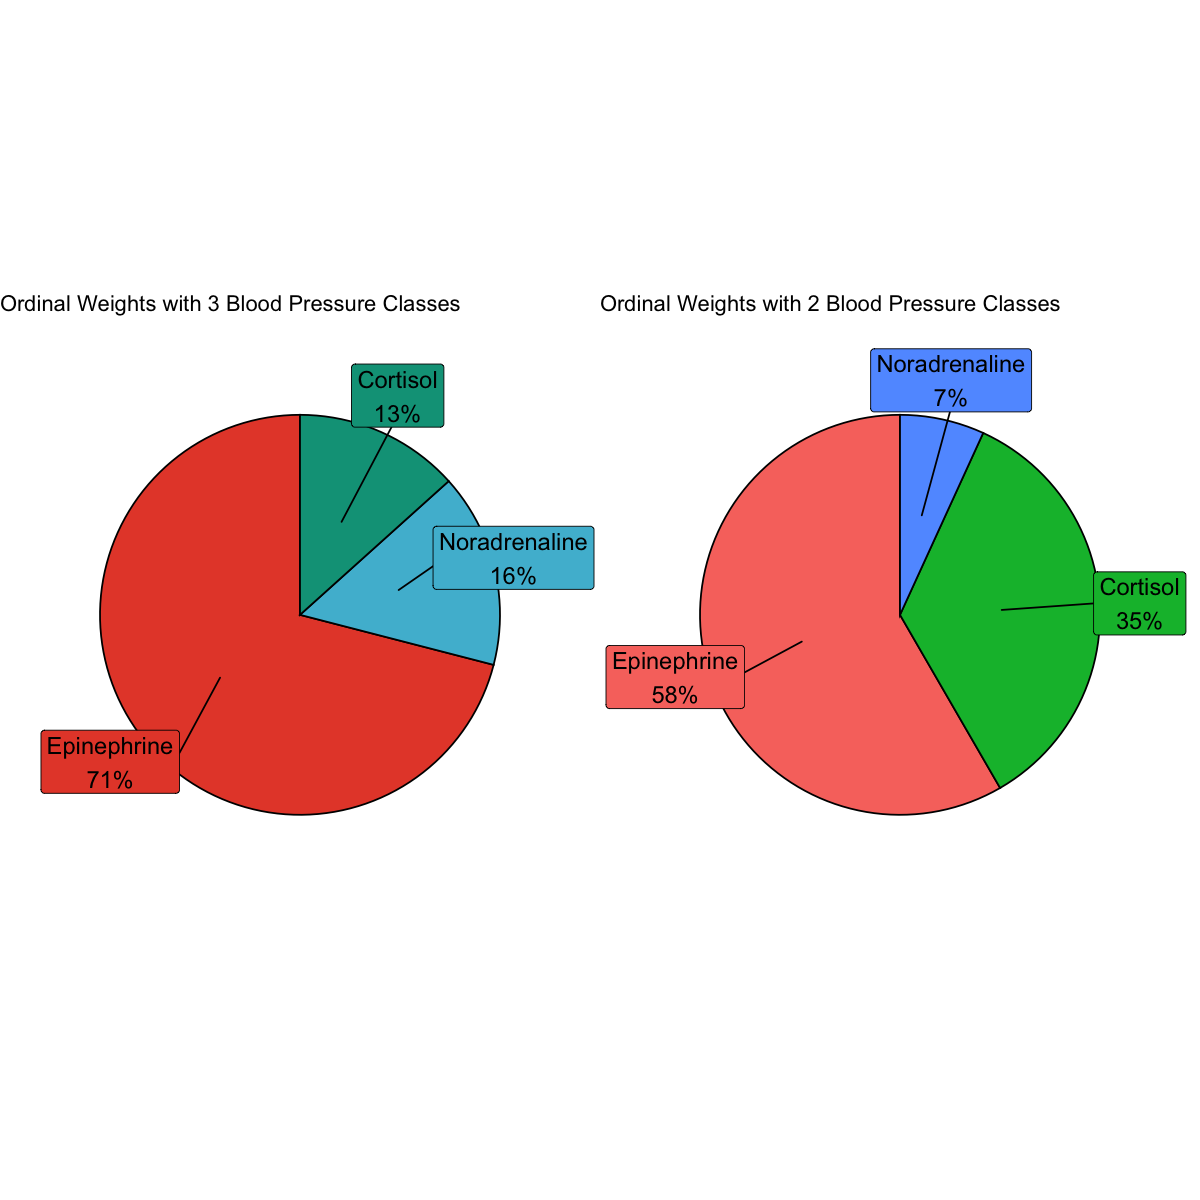

In [16]:
plot_grid(piechart3, piechart2)

Based on these results, epinephrine had the largest contribution to blood pressure classification in both cases. 

## Acute Allostatic Load Summation

Now that we have these weights from the ordinal regression, we'll calculate allostatic load scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 4 acute biomarkers (cortisol, noradrenaline, epinephrine, fibrinogen). AL scores will be calculated for all 63 subjects not just the 34 with BP data. The formula looks like...

Allostatic Load = Cortisol ordinal weight * Cortisol score + Epinephrine ordinal weight * Epinephrine score...

In [17]:
acute_allostatic_load = function(weights_df){
    # add words!!
    
    # combining the mediator scores for all 63 subjects with the ordinal weights into one dataframe
    wider_weights_df = mediator_scores_df %>%
        filter(Variable %in% acute_biomarkers) %>%
        mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
        dcast(Variable ~ Subject_ID, value.var = "Mediator_Score") %>% 
        inner_join(weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Acute_Load = apply(multiplication_df, 2, sum)) %>%
        arrange(-Acute_Load) %>%
        rownames_to_column(var = "Subject_ID")
    
    return(allostatic_load_df)
    }

# calling fn
three_acute_allostatic_df = acute_allostatic_load(three_weights_df)
two_acute_allostatic_df = acute_allostatic_load(two_weights_df)

head(three_acute_allostatic_df)

Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`


,Subject_ID,Acute_Load
,<chr>,<dbl>
1,NS_M_28_W_51,0.8069382
2,NS_F_23_W_41,0.5635610
3,CS_M_28_W_16,0.5400870
4,NS_F_21_W_38,0.5112396
5,CS_M_29_W_17,0.4616988
6,NS_F_38_B_61,0.4394047


# Chronic AL 

This involves normalizing their mediator scores, multiplying HDL by -1 since it's considered protective against atherosclerotic risk, and summing them to get the chronic AL score.

These biomarkers are essentially weighted with 1 or -1.

In [18]:
chronic_biomarkers = c('Hba1c','CRP', 'HDL','Fibrinogen')

chronic_allostatic_df = mediator_scores_df %>%
    # filtering for chronic biomarkers
    filter(Variable %in% chronic_biomarkers) %>%
    # normalizing
    mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
    # making HDL negative
    mutate(Mediator_Score = ifelse(Variable == "HDL", Mediator_Score * -1, Mediator_Score)) %>%
    # summing for each subject
    group_by(Subject_ID) %>%
    summarize(Chronic_Score = sum(Mediator_Score)) %>%
    # rescaling so that these numbers fall between 0 and 1
    mutate(Chronic_Load = (Chronic_Score  - min(Chronic_Score))/ (max(Chronic_Score) - min(Chronic_Score))) %>%
    select(-Chronic_Score) %>%
    arrange(-Chronic_Load)

head(chronic_allostatic_df)

Subject_ID,Chronic_Load
<chr>,<dbl>
NS_F_42_B_62,1.0000000
CS_F_39_W_32,0.8849612
NS_F_28_B_53,0.8810224
NS_F_35_B_59,0.8382134
NS_F_27_B_50,0.8268365
NS_F_23_W_41,0.7215899


# Overall AL

Summing the acute and chronic AL scores. These scores range from 0-2.

In [19]:
allostatic_three_df = inner_join(three_acute_allostatic_df, chronic_allostatic_df) %>%
    mutate(Allostatic_Load = Acute_Load + Chronic_Load)

allostatic_two_df = inner_join(two_acute_allostatic_df, chronic_allostatic_df) %>%
    mutate(Allostatic_Load = Acute_Load + Chronic_Load)

head(allostatic_three_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Load,Chronic_Load,Allostatic_Load
,<chr>,<dbl>,<dbl>,<dbl>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227


In [20]:
# # seeing if this data is normal
# do.call(rbind.data.frame, apply(allostatic_three_df[,2:4], 2, shapiro.test))[,1:3] %>%
#     mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

# do.call(rbind.data.frame, apply(allostatic_two_df[,2:4], 2, shapiro.test))[,1:3] %>%
#     mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

In [21]:
# # it's not so normalizing
# norm_allostatic_three_df = allostatic_three_df %>%
#     mutate(across(Acute_Load:Allostatic_Load, ~ log2(.x + 1)))

# norm_allostatic_two_df = allostatic_two_df %>%
#     mutate(across(Acute_Load:Allostatic_Load, ~ log2(.x + 1)))

# head(norm_allostatic_three_df)

In [22]:
# # seeing if this data is normal
# do.call(rbind.data.frame, apply(norm_allostatic_three_df[,2:4], 2, shapiro.test))[,1:3] %>%
#     mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

# do.call(rbind.data.frame, apply(norm_allostatic_two_df[,2:4], 2, shapiro.test))[,1:3] %>%
#     mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

Now testing for statistical differences based on sex, race, and smoking status using a two way anova.

In [23]:
# adding in demographic info for each subject
three_anova_df = inner_join(allostatic_three_df, subject_info_df[,c(3,5,6,8)])
two_anova_df = inner_join(allostatic_two_df, subject_info_df[,c(3,5,6,8)])


# converting into factors
three_anova_df$Smoking_Status = factor(three_anova_df$Smoking_Status, levels = c("NS", "CS"))
three_anova_df$Sex = factor(three_anova_df$Sex, levels = c("M", "F"))
three_anova_df$Race = factor(three_anova_df$Race, levels = c("W", "B"))
two_anova_df$Smoking_Status = factor(two_anova_df$Smoking_Status, levels = c("NS", "CS"))
two_anova_df$Sex = factor(two_anova_df$Sex, levels = c("M", "F"))
two_anova_df$Race = factor(two_anova_df$Race, levels = c("W", "B"))

head(three_anova_df)

# looking at counts for each variable
# table(three_anova_df[,c(5:6)])
# table(three_anova_df[,c(5,7)])

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Load,Chronic_Load,Allostatic_Load,Smoking_Status,Sex,Race
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087,NS,M,W
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509,NS,F,W
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317,CS,M,W
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049,NS,F,W
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658,CS,M,W
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227,NS,F,B


In [24]:
# anova
three_anova_smoking_race = aov(Allostatic_Load ~ Smoking_Status * Race, data = three_anova_df)
three_anova_smoking_sex = aov(Allostatic_Load ~ Smoking_Status * Sex, data = three_anova_df)
three_anova_sex_race = aov(Allostatic_Load ~ Sex * Race, data = three_anova_df)
two_anova_smoking_race = aov(Allostatic_Load ~ Smoking_Status * Race, data = two_anova_df)
two_anova_smoking_sex = aov(Allostatic_Load ~ Smoking_Status * Sex, data = two_anova_df)
two_anova_sex_race = aov(Allostatic_Load ~ Sex * Race, data = two_anova_df)

In [25]:
summary(three_anova_smoking_race) 
summary(three_anova_smoking_sex)
summary(three_anova_sex_race)

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1  0.242 0.24185   2.843 0.0970 .
Race                 1  0.285 0.28467   3.347 0.0724 .
Smoking_Status:Race  1  0.204 0.20408   2.399 0.1267  
Residuals           59  5.018 0.08506                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)
Smoking_Status      1  0.242 0.24185   2.641  0.109
Sex                 1  0.045 0.04512   0.493  0.485
Smoking_Status:Sex  1  0.059 0.05937   0.648  0.424
Residuals          59  5.403 0.09157               

            Df Sum Sq Mean Sq F value  Pr(>F)   
Sex          1  0.006  0.0059   0.074 0.78659   
Race         1  0.261  0.2609   3.277 0.07533 . 
Sex:Race     1  0.785  0.7848   9.857 0.00264 **
Residuals   59  4.697  0.0796                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [26]:
summary(two_anova_smoking_race)
summary(two_anova_smoking_sex)
summary(two_anova_sex_race)

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1  0.242 0.24213   3.076 0.0847 .
Race                 1  0.301 0.30128   3.827 0.0552 .
Smoking_Status:Race  1  0.224 0.22440   2.850 0.0966 .
Residuals           59  4.645 0.07873                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status      1  0.242 0.24213   2.811 0.0989 .
Sex                 1  0.006 0.00605   0.070 0.7919  
Smoking_Status:Sex  1  0.083 0.08274   0.961 0.3310  
Residuals          59  5.082 0.08613                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)   
Sex          1  0.003  0.0028   0.037 0.84866   
Race         1  0.274  0.2740   3.542 0.06476 . 
Sex:Race     1  0.573  0.5727   7.404 0.00854 **
Residuals   59  4.563  0.0773                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [27]:
three_anova_df %>%
    tukey_hsd(Allostatic_Load ~ Sex * Race) %>%
    # only keeping interaction results
    filter(term == 'Sex:Race') %>%
    rename('Sex:Race' = 'term') #%>%
    #add_xy_position(x = "Sex:Race")

Sex:Race,group1,group2,null.value,estimate,conf.low,conf.high,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Sex:Race,M:W,F:W,0,-0.24843203,-0.52082648,0.02396241,0.08600,ns
Sex:Race,M:W,M:B,0,-0.16599515,-0.47738599,0.14539569,0.49900,ns
Sex:Race,M:W,F:B,0,0.04948910,-0.22290534,0.32188355,0.96300,ns
Sex:Race,F:W,M:B,0,0.08243688,-0.19758913,0.36246290,0.86400,ns
Sex:Race,F:W,F:B,0,0.29792114,0.06202063,0.53382165,0.00776,**
Sex:Race,M:B,F:B,0,0.21548425,-0.06454176,0.49551027,0.18700,ns


In [28]:
# # post hoc for sex and race anova
# three_tukey = TukeyHSD(three_anova_sex_race)
# two_tukey = TukeyHSD(two_anova_sex_race)

# three_tukey_df = data.frame(three_tukey$`Sex:Race`) %>%
#     #mutate(p.adj.signif = ifelse(p.adj < 0.05, "*", "ns")) %>%
#     # adding a col that contains the label to be plotted
#     add_significance("p.adj") %>%
#     mutate(`.y.` = "Allostatic_Load", group1 = "Sex", group2 = "Race")
#     #rownames_to_column(var = 'Comparison') %>%
#     #separate(Comparison, sep = "-", into = c("group1", "group2")) %>%
#     # adding a col that will tell ggplot where to plot these numbers
#     add_xy_position(x = "Sex", step.increase = 2)
# two_tukey_df = data.frame(two_tukey$`Sex:Race`) %>%
#      mutate(p.adj.signif = ifelse(p.adj < 0.05, "*", "ns"))

# head(three_tukey_df)

There are statistically significant differences in allostatic load based on race (p value = 0.04) and the interaction between race and sex (p value = 0.007). These significant differences were present using ordinal weights from blood pressure classification with two classes and three classes. This indicates that the ordinal weights from either cases didn't have a substantial impact on the statistical results.

Tukey's post hoc tests revealed that black females have a higher overall AL than white females.

,Subject_ID,Acute_Load,Chronic_Load,Allostatic_Load,Smoking_Status,Sex:Race,Sex,Race
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>,<fct>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087,NS,M:W,M,W
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509,NS,F:W,F,W
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317,CS,M:W,M,W
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049,NS,F:W,F,W
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658,CS,M:W,M,W
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227,NS,F:B,F,B


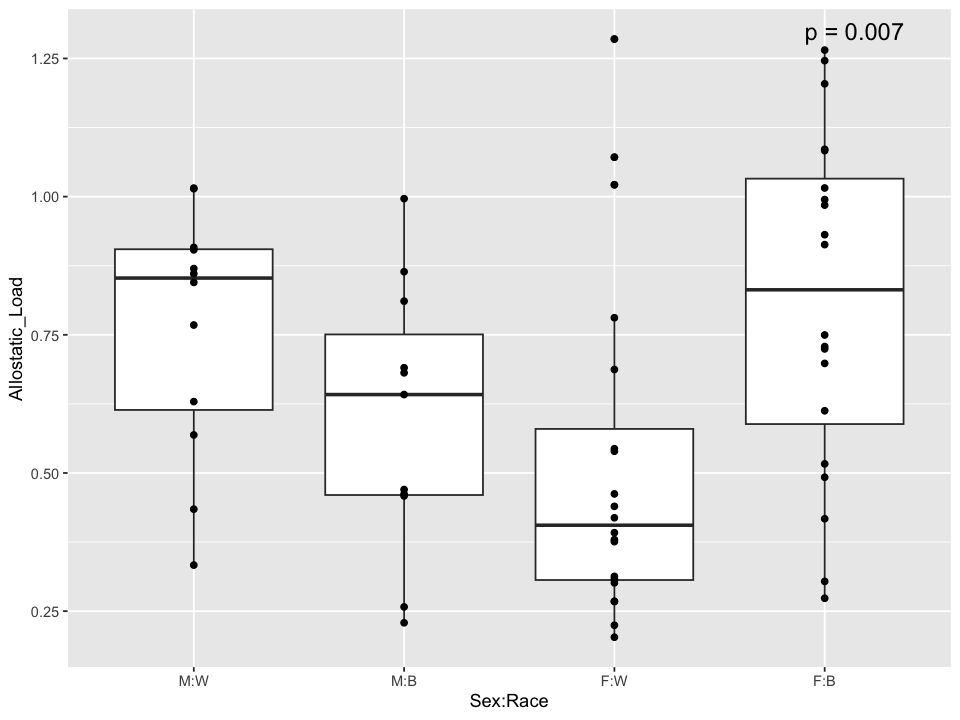

In [29]:
options(repr.plot.width=8, repr.plot.height=6) #changing size
boxplot_df = three_anova_df %>%
    unite(`Sex:Race`, Sex, Race, sep = ":", remove = FALSE)

head(boxplot_df)

ggplot(data = boxplot_df, aes(x = Sex:Race, y = Allostatic_Load)) + 
  geom_boxplot() + 
  geom_point() + 
  stat_anova_test(wid = "Sex:Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "right", size = 5) #+
  #stat_pvalue_manual(three_tukey_df, label = "p.adj.signif", size = 12, hide.ns = TRUE)

In [30]:
# ggplot(data = boxplot_df, aes(x = Race, y = Allostatic_Load)) + 
#   geom_boxplot() + 
#   geom_point() + 
#   stat_anova_test(wid = "Race", p.adjust.method = "none", label = "p = {p.format}", 
#                      label.x.npc = "right", size = 5) 

Now looking at statistical differences between acute and chronic AL.

In [31]:
# acute AL anova
three_anova_smoking_race = aov(Acute_Load ~ Smoking_Status * Race, data = three_anova_df)
three_anova_smoking_sex = aov(Acute_Load ~ Smoking_Status * Sex, data = three_anova_df)
three_anova_sex_race = aov(Acute_Load ~ Sex * Race, data = three_anova_df)
two_anova_smoking_race = aov(Acute_Load ~ Smoking_Status * Race, data = two_anova_df)
two_anova_smoking_sex = aov(Acute_Load ~ Smoking_Status * Sex, data = two_anova_df)
two_anova_sex_race = aov(Acute_Load ~ Sex * Race, data = two_anova_df)

In [32]:
summary(three_anova_smoking_race) 
summary(three_anova_smoking_sex)
summary(three_anova_sex_race)

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1 0.0758 0.07580   4.056 0.0486 *
Race                 1 0.0108 0.01079   0.577 0.4503  
Smoking_Status:Race  1 0.0052 0.00518   0.277 0.6007  
Residuals           59 1.1027 0.01869                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status      1 0.0758 0.07580   4.311 0.0422 *
Sex                 1 0.0788 0.07876   4.480 0.0385 *
Smoking_Status:Sex  1 0.0026 0.00262   0.149 0.7011  
Residuals          59 1.0373 0.01758                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)  
Sex          1 0.0396 0.03964   2.276 0.1367  
Race         1 0.0128 0.01276   0.733 0.3955  
Sex:Race     1 0.1145 0.11451   6.575 0.0129 *
Residuals   59 1.0276 0.01742                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [33]:
summary(two_anova_smoking_race)
summary(two_anova_smoking_sex)
summary(two_anova_sex_race)

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1 0.0760 0.07596   4.740 0.0335 *
Race                 1 0.0078 0.00784   0.489 0.4870  
Smoking_Status:Race  1 0.0088 0.00882   0.550 0.4611  
Residuals           59 0.9455 0.01603                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status      1 0.0760 0.07596   4.809 0.0323 *
Sex                 1 0.0213 0.02132   1.350 0.2500  
Smoking_Status:Sex  1 0.0090 0.00905   0.573 0.4521  
Residuals          59 0.9318 0.01579                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)
Sex          1 0.0048 0.00477   0.287  0.594
Race         1 0.0101 0.01007   0.607  0.439
Sex:Race     1 0.0438 0.04379   2.638  0.110
Residuals   59 0.9795 0.01660               

In [34]:
# post hoc for sex and race anova
three_tukey = TukeyHSD(three_anova_sex_race)

three_tukey_df = data.frame(three_tukey$`Sex:Race`) %>%
    #mutate(p.adj.signif = ifelse(p.adj < 0.05, "*", "ns")) %>%
    # adding a col that contains the label to be plotted
    add_significance("p.adj")

three_tukey_df

,diff,lwr,upr,p.adj,p.adj.signif
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
F:W-M:W,-0.137635630,-0.26503874,-0.010232521,0.02935339,*
M:B-M:W,-0.141063529,-0.28670586,0.004578799,0.06100251,ns
F:B-M:W,-0.101490452,-0.22889356,0.025912657,0.16310823,ns
M:B-F:W,-0.003427899,-0.13440041,0.127544616,0.99987973,ns
F:B-F:W,0.036145178,-0.07418915,0.146479507,0.82224316,ns
F:B-M:B,0.039573077,-0.09139944,0.170545592,0.85467628,ns


There are statistically significant differences in acute allostatic load (stress) between non-smokers and cigarette smokers (p value = 0.02). The interaction between sex and race was significant when using the ordinal weights derived from the 3 class BP prediction. Tukey's post hoc tests revealed that white males have a lower acute AL than white females (p adj < 0.05).

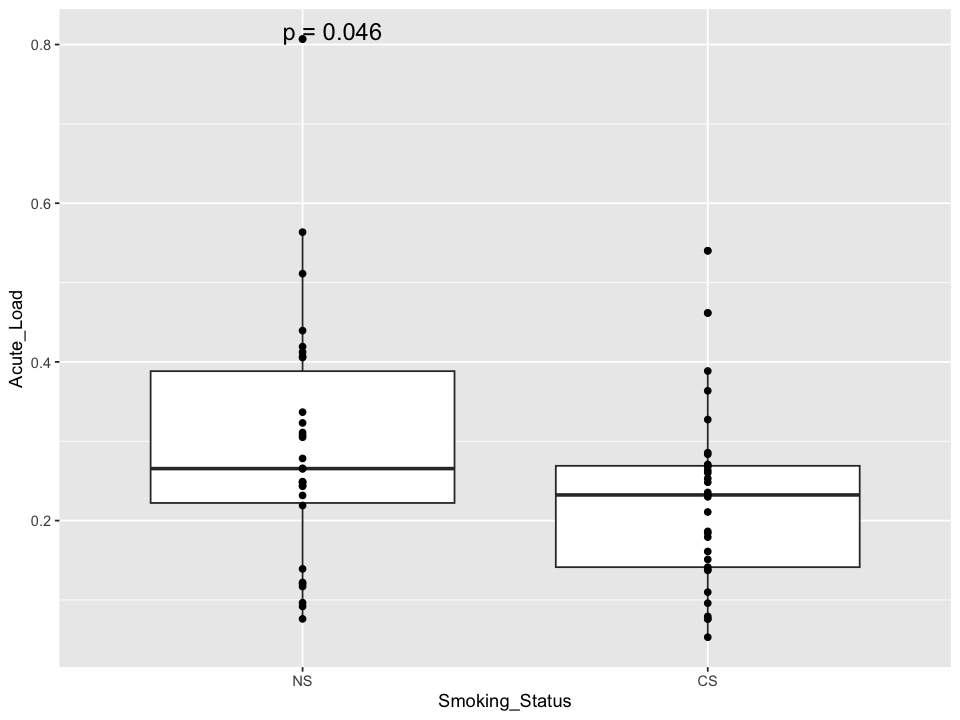

In [35]:
# # visualizing using boxplots
options(repr.plot.width=8, repr.plot.height=6) #changing size

ggplot(data = three_anova_df, aes(y = Acute_Load, x = Smoking_Status)) + 
  geom_boxplot() +
  geom_point() + 

 stat_anova_test(wid = "Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 5)

In [36]:
# insert another boxplot for sex and race

In [37]:
# chronic AL anova
three_anova_smoking_race = aov(Chronic_Load ~ Smoking_Status * Race, data = three_anova_df)
three_anova_smoking_sex = aov(Chronic_Load ~ Smoking_Status * Sex, data = three_anova_df)
three_anova_sex_race = aov(Chronic_Load ~ Sex * Race, data = three_anova_df)
two_anova_smoking_race = aov(Chronic_Load ~ Smoking_Status * Race, data = two_anova_df)
two_anova_smoking_sex = aov(Chronic_Load ~ Smoking_Status * Sex, data = two_anova_df)
two_anova_sex_race = aov(Chronic_Load ~ Sex * Race, data = two_anova_df)

In [38]:
summary(three_anova_smoking_race) 
summary(three_anova_smoking_sex)
summary(three_anova_sex_race)

                    Df Sum Sq Mean Sq F value  Pr(>F)   
Smoking_Status       1 0.0469  0.0469   0.877 0.35274   
Race                 1 0.4063  0.4063   7.608 0.00772 **
Smoking_Status:Race  1 0.1442  0.1442   2.701 0.10561   
Residuals           59 3.1510  0.0534                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)
Smoking_Status      1  0.047 0.04686   0.755  0.388
Sex                 1  0.005 0.00466   0.075  0.785
Smoking_Status:Sex  1  0.037 0.03706   0.597  0.443
Residuals          59  3.660 0.06203               

            Df Sum Sq Mean Sq F value  Pr(>F)   
Sex          1 0.0150  0.0150   0.290 0.59221   
Race         1 0.3891  0.3891   7.540 0.00799 **
Sex:Race     1 0.2997  0.2997   5.808 0.01909 * 
Residuals   59 3.0446  0.0516                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [39]:
summary(two_anova_smoking_race)
summary(two_anova_smoking_sex)
summary(two_anova_sex_race)

                    Df Sum Sq Mean Sq F value  Pr(>F)   
Smoking_Status       1 0.0469  0.0469   0.877 0.35274   
Race                 1 0.4063  0.4063   7.608 0.00772 **
Smoking_Status:Race  1 0.1442  0.1442   2.701 0.10561   
Residuals           59 3.1510  0.0534                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)
Smoking_Status      1  0.047 0.04686   0.755  0.388
Sex                 1  0.005 0.00466   0.075  0.785
Smoking_Status:Sex  1  0.037 0.03706   0.597  0.443
Residuals          59  3.660 0.06203               

            Df Sum Sq Mean Sq F value  Pr(>F)   
Sex          1 0.0150  0.0150   0.290 0.59221   
Race         1 0.3891  0.3891   7.540 0.00799 **
Sex:Race     1 0.2997  0.2997   5.808 0.01909 * 
Residuals   59 3.0446  0.0516                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [40]:
# post hoc for sex and race anova
three_tukey = TukeyHSD(three_anova_sex_race)

three_tukey_df = data.frame(three_tukey$`Sex:Race`) %>%
    #mutate(p.adj.signif = ifelse(p.adj < 0.05, "*", "ns")) %>%
    # adding a col that contains the label to be plotted
    add_significance("p.adj")

three_tukey_df

,diff,lwr,upr,p.adj,p.adj.signif
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
F:W-M:W,-0.11079640,-0.33009600,0.1085032,0.544258576,ns
M:B-M:W,-0.02493162,-0.27562648,0.2257632,0.993566136,ns
F:B-M:W,0.15097956,-0.06832004,0.3702792,0.274269876,ns
M:B-F:W,0.08586478,-0.13957885,0.3113084,0.745987071,ns
F:B-F:W,0.26177596,0.07185694,0.4516950,0.003108027,**
F:B-M:B,0.17591118,-0.04953246,0.4013548,0.177324698,ns


There are statistically significant differences in chronic allostatic load (stress) based on race (p value = 0.03). The interaction between sex and race was significant (p value < 0.01). 

Tukey's post hoc tests revealed that white females have a higher chronic AL than black females (p adj < 0.05).

In [41]:
# insert another boxplot for sex and race

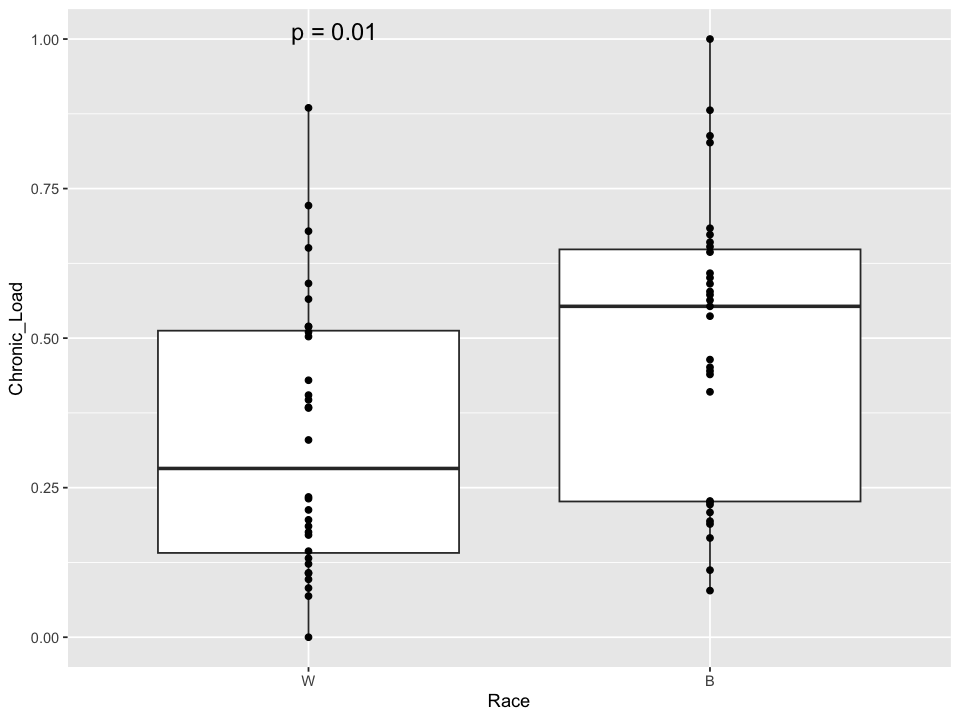

In [42]:
ggplot(data = three_anova_df, aes(y = Chronic_Load, x = Race)) + 
  geom_boxplot() +
  geom_point() + 

 stat_anova_test(wid = "Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 5)

# Recap of Significant Results
**Overall AL**
+ *Interaction of Sex and Race*
    + black females have a higher overall AL than white females
    + Putting Fibrinogen into the chronic AL allowed the two-way anova to pick up more potential significant associations including smoking status and race

**Acute AL**
+ *Smoking Status*
    + non-smokers had a higher acute AL than cigarette smokers
+ *Race*
    + Removing Fibrinogen made this significant, but only when using the 3 class ordinal weights
+ *Interaction of Sex and Race*
    + only significant when using the ordinal weights derived from the 3 class BP prediction
    + white females have a higher acute AL than white males

**Chronic AL**
+ *Race*
  + black subjects have a higher chronic AL than white subjects
  + Adding Fibrinogen made this even more significant
+ *Interaction of Sex and Race*
    + black females have a higher chronic AL than white females